# ICBC Black-Litterman Model

 ### 本模型所用变量描述
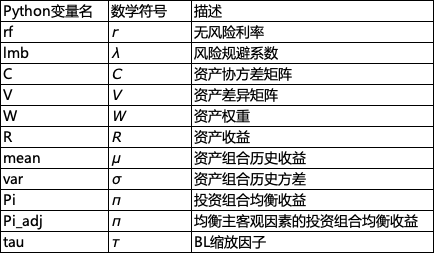

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## 模型引用库

In [2]:
# %load /Users/zhanghongkun/PycharmProjects/selfBL/BlackLitterman.py
from matplotlib import pyplot
plt = pyplot
from pylab import *
import scipy.optimize
import pandas as pd
import numpy as np
import regex as re
from scipy.interpolate import spline

pd.set_option('expand_frame_repr', True)
pd.set_option('display.max_columns', 10)

## 数据输入
加载数据文件，读取各产品时间戳、净值、市值等信息

In [3]:
# XOM   埃克森美孚   AAPL    苹果      MSFT   微软
# JNJ   强生         GE    通用电气   GOOG    谷歌
# CVX   雪弗龙       PG     宝洁       WFC   富国银行

def load_data():
    symbols = [
               'BSX',
               'FGJ',
               'PHZ',
                'PF3',
                'PF6',
               'PFB',
               'DCJ',
               'DFH',
               'CVX',
               'GOOG',
    ]
    cap = {
           'BSX': 5.90e9,
           'FGJ': 1.663e9,
           'PHZ': 7.339e9,
           'PF3': 25.10e9,
           'PF6': 25.982e9,
           'PFB': 25.69e9,
           'DCJ': 2.127e9,
           'DFH': 3.077e9,
           'CVX':2.3103e9,
           'GOOG': 2.9272e9,
    }
    prices_out, caps_out, date_out = [], [], []
    for s in symbols:
        dataframe = pd.read_csv('databank/%s.csv' % s, index_col=None, parse_dates=['date'])
        prices = list(dataframe['price'])[-240:] # 追溯240条数据
        date = list(dataframe['date'][-240:])
        # print(prices)
        date_out.append(date)
        prices_out.append(prices)
        caps_out.append(cap[s])
    return symbols, prices_out, caps_out, date_out

In [4]:
names, prices, caps, dates= load_data()


## 输入主观观点以及约束条件 
输入示例：

主观观点"GOOG>PF3=0.002;PF6>PFB=0.004"

约束条件"PF6<0.1"

In [5]:
line = input('输入你的观点：')
line1 = input('输入约束条件：')

输入你的观点：GOOG>PF3=0.002;PF6>PFB=0.004
输入约束条件：PF6<0.1


## 数据加工
计算BL公式中涉及的风险规避系数、资产协方差矩阵、资产收益矩阵、资产差异、资产权重等

In [6]:
# 将历史股票价格与市值一起计算，并计算权重，历史收益和历史协方差
def assets_historical_returns_and_covariances(prices):
    prices = matrix(prices)  # 为价格创建numpy矩阵
    # 创建历史收益矩阵
    rows, cols = prices.shape
    returns = empty([rows, cols - 1])
    for r in range(rows):
        for c in range(cols - 1):
            p0, p1 = prices[r, c], prices[r, c + 1]
            returns[r, c] = (p1 / p0) - 1
    # 计算收益
    expreturns = array([])
    for r in range(rows):
        expreturns = append(expreturns, np.mean(returns[r]))
    # 计算协方差
    covars = cov(returns)
    expreturns = (1 + expreturns) ** 360 - 1  # 年度回报
    covars = covars * 360  # 年度协方差
    return returns,expreturns, covars


# 计算投资组合平均收益
def port_mean(W, R):
    return sum(R * W)

# 计算收益的投资组合方差
def port_var(W, C):
    return dot(dot(W, C), W)

# port_mean和port_var的组合 - 收益计算的均值和方差
def port_mean_var(W, R, C):
    return port_mean(W, R), port_var(W, C)

In [7]:
n = len(names)
W = array(caps) / sum(caps)  # 计算股票市场权重
ret, R, C = assets_historical_returns_and_covariances(prices)
rf = .003  # 无风险利率
display(pd.DataFrame({'资产收益': R, '市场权重': W}, index=names).T)
print('资产协方差')
display(pd.DataFrame(C, columns=names, index=names))
# 计算投资组合历史收益和方差
mean, var = port_mean_var(W, R, C)
lmb = (mean - rf) / var  # 计算风险规避
np.set_printoptions(suppress=True)
Pi = dot(dot(lmb, C), W)  # 计算均衡超额收益

print('投资组合历史收益')
display(mean)
print('投资组合历史方差')
display(var)
print('风险规避系数')
display(lmb)

,BSX,FGJ,PHZ,PF3,PF6,PFB,DCJ,DFH,CVX,GOOG
资产收益,-0.090617,0.253045,-0.002113,0.064176,0.063077,0.040193,-0.061654,-0.179127,0.188129,0.974107
市场权重,0.057778,0.016285,0.071870,0.245800,0.254437,0.251578,0.020829,0.030133,0.022624,0.028666


资产协方差


,BSX,FGJ,PHZ,PF3,PF6,PFB,DCJ,DFH,CVX,GOOG
BSX,0.028679,0.043972,0.013922,-6.859477e-05,-1.139816e-05,1.848820e-05,-0.001308,0.020509,-0.001933,0.001385
FGJ,0.043972,0.114708,0.025762,-1.035613e-04,-7.294007e-05,-4.181751e-05,-0.001738,0.038816,-0.002009,0.005368
PHZ,0.013922,0.025762,0.113654,6.517021e-04,8.202253e-05,5.553808e-05,-0.001840,0.056560,0.000402,0.003140
PF3,-0.000069,-0.000104,0.000652,1.242161e-04,6.102138e-06,-6.750028e-07,0.000017,0.000451,0.000120,0.000244
PF6,-0.000011,-0.000073,0.000082,6.102138e-06,8.715006e-06,8.983540e-07,0.000001,-0.000039,0.000021,0.000024
PFB,0.000018,-0.000042,0.000056,-6.750028e-07,8.983540e-07,3.743782e-06,0.000008,0.000018,-0.000054,-0.000006
DCJ,-0.001308,-0.001738,-0.001840,1.670517e-05,1.199341e-06,8.126428e-06,0.005312,-0.001465,0.000242,0.001842
DFH,0.020509,0.038816,0.056560,4.507479e-04,-3.943907e-05,1.817691e-05,-0.001465,0.080312,0.001011,-0.001023
CVX,-0.001933,-0.002009,0.000402,1.198461e-04,2.145273e-05,-5.426486e-05,0.000242,0.001011,0.034589,0.016135
GOOG,0.001385,0.005368,0.003140,2.441973e-04,2.381020e-05,-5.673098e-06,0.001842,-0.001023,0.016135,0.060653


投资组合历史收益


0.06616672547238818

投资组合历史方差


0.0015426415008401608

风险规避系数


40.94711923540629

## 观点矩阵提取及计算
将输入的观点转换为观点矩阵并进行代入BL公式中进行运算

In [8]:
def create_views_and_link_matrix(names, views):
    r, c = len(views), len(names)
    if not r:
        P = zeros([1,c])
        Q = [0.]
        return Q, P
    else:
        Q = [views[i][3] for i in range(r)]  # view matrix
        P = zeros([r, c])
        nameToIndex = dict()

        for i, n in enumerate(names):
            nameToIndex[n] = i

        for i, v in enumerate(views):
            name1, name2 = views[i][0], views[i][2]
            P[i, nameToIndex[name1]] = +1 if views[i][1] == '>' else -1
            P[i, nameToIndex[name2]] = -1 if views[i][1] == '>' else +1

        # P = zeros([r, c])
        return array(Q), P

def str_to_views(string):
    views=[]
    def append_obj(string):
        obj = re.match(r'(.*)>(.*)=(.*)', string, re.M | re.I)
        if obj:
            compare='>'
        else:
            obj = re.match(r'(.*)<(.*)=(.*)', string, re.M | re.I)
            compare='<'
        objs = [obj.group(1),compare,obj.group(2),float(obj.group(3))]
        views.append(objs)

    while string !="":
        match = re.match(r'(.*?);(.*)',string, re.M | re.I)
        if match:
            append_obj(match.group(1))
            string = match.group(2)
        else:
            append_obj(string)
            string = ""
    return views

In [9]:
views = str_to_views(line)
tau = .025  # 缩放因子
sub_a = inv(dot(tau, C))
sub_c = dot(inv(dot(tau, C)), Pi)
if views:
    Q, P = create_views_and_link_matrix(names, views)
    print('观点矩阵Q')
    display(pd.DataFrame({'Views':Q}))
    print('资产收益的观点向量P')
    display(pd.DataFrame(P))
    # 计算主观因素的不确定性矩阵omega
    omega = dot(dot(dot(tau, P), C), transpose(P))  # [(0.025 * P) * C] * P转置
    sub_b = dot(dot(transpose(P), inv(omega)), P)
    sub_d = dot(dot(transpose(P), inv(omega)), Q)
    # 合并主客观因素，计算均衡超额收益
    Pi_adj = dot(inv(sub_a + sub_b), (sub_c + sub_d))
else:
    Pi_adj = dot(inv(sub_a), sub_c)
print('合并主客观因素后的均衡收益矩阵')
display(pd.DataFrame(Pi_adj))

观点矩阵Q


,Views
0,0.002
1,0.004


资产收益的观点向量P


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0


合并主客观因素后的均衡收益矩阵


,0
0,0.154778
1,0.294374
2,0.467475
3,0.005096
4,0.001743
5,-0.000324
6,-0.007192
7,0.333504
8,0.048161
9,0.056713


## 计算BL曲线以及个性化资产配置权重 

In [10]:
class Result:
    def __init__(self, W, tan_mean, tan_var, front_mean, front_var):
        self.W = W
        self.tan_mean = tan_mean
        self.tan_var = tan_var
        self.front_mean = front_mean
        self.front_var = front_var


def optimize_frontier(R, C, rf, st):
    W = solve_weights(R, C, rf, st)
    tan_mean, tan_var = port_mean_var(W, R, C)  # 计算相切投资组合
    front_mean, front_var = solve_frontier(R, C)  # 计算有效边界
    # 权重，相切组合资产均值和方差，有效边界均值和方差
    return Result(W, tan_mean, tan_var, front_mean, front_var)

In [11]:
# 给定无风险利率，资产收益率和协方差，此函数计算均值-方差边界并在两个数组中返回其[x，y]点
def solve_frontier(R, C):
    def fitness(W, R, C, r):
        # 对于给定的收益水平r，找到最小化投资组合方差的权重。
        mean, var = port_mean_var(W, R, C)
        penalty = 100 * abs(mean - r)  # 不符合规定的投资组合收益的惩罚作为优化的约束方式
        return var + penalty

    frontier_mean, frontier_var = [], []
    n = len(R)  # 投资组合中的资产数量
    for r in linspace(min(R), max(R), num=30):  # 迭代Y轴上的返回范围
        W = ones([n]) / n  # 以相同的权重开始优化
        b_ = [(0, 1) for i in range(n)]
        c_ = ({ 'type': 'eq',
                'fun': lambda W: sum(W) - 1.
              })
        optimized = scipy.optimize.minimize(fitness, W, (R, C, r), method='SLSQP', constraints=c_, bounds=b_)
        if not optimized.success:
            raise BaseException(optimized.message)
        # 为有效边界添加点[x,y] = [optimized.x, r]
        frontier_mean.append(r)
        frontier_var.append(port_var(optimized.x, C))
    return frontier_mean, frontier_var


# 给定无风险利率，资产收益率和协方差，此函数计算夏普比率最大化的相切投资组合的权重
def solve_weights(R, C, rf, stri):
    def fitness(W, R, C, rf):
        mean, var = port_mean_var(W, R, C)  # 计算投资组合的均值/方差
        util = (mean - rf) / sqrt(var)  # utility = 夏普比率
        return 1 / util  # 最大化utility，最小化其反向值

    def str_to_constraint(string):
        constraint=[{'type': 'eq', 'fun': lambda W1: sum(W1) - 1.}]
        symbols = {
            'BSX':0,
            'FGJ':1,
            'PHZ':2,
            'PF3':3,
            'PF6':4,
            'PFB':5,
            'DCJ':6,
            'DFH':7,
            'CVX':8,
            'GOOG':9
        }
        def append_obj(string):
            obj = re.match(r'(.*)>(.*)', string, re.M | re.I)
            if obj:
                compare='>'
            else:
                obj = re.match(r'(.*)<(.*)', string, re.M | re.I)
                compare='<'
            if compare=='>':
                objs = {'type': 'ineq', 'fun': lambda W1: W1[symbols[obj.group(1)]] - float(obj.group(2))}
            else:
                objs = {'type': 'ineq', 'fun': lambda W1: float(obj.group(2)) - W1[symbols[obj.group(1)]]}
            constraint.append(objs)

        while string !="":
            match = re.match(r'(.*?);(.*)',string, re.M | re.I)
            if match:
                append_obj(match.group(1))
                string = match.group(2)
            else:
                append_obj(string)
                string = ""
        return constraint
    n = len(R)
    W = ones([n]) / n  # 以相同的权重开始优化
    b_ = [(0., 1.) for i in range(n)]  # 边界的权重在0％... 100％之间。
    c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})  # 权重总和必须为100％
    optimized = scipy.optimize.minimize(fitness, W, (R, C, rf), method='SLSQP', constraints=c_, bounds=b_)
    for i in range(n):
        optimized.x[i]=round(optimized.x[i],4)
    # print(optimized.x)
    W1=optimized.x
    # print(W1[0])
    b_1 = [(0., 1.) for i in range(n)]  # 边界的权重在0％... 100％之间。
    c_1 = str_to_constraint(stri)
    optimized = scipy.optimize.minimize(fitness, W1, (R, C, rf), method='SLSQP', constraints=c_1, bounds=b_1)

    for i in range(n):
        optimized.x[i]=round(optimized.x[i],4)
    # print(optimized.x[0])
    # print(optimized.x)
    if not optimized.success: raise BaseException(optimized.message)
    return optimized.x

In [12]:
res = optimize_frontier(Pi_adj + rf, C, rf, line1)

display(pd.DataFrame({'主观权重': res.W}, index=names).T)

,BSX,FGJ,PHZ,PF3,PF6,PFB,DCJ,DFH,CVX,GOOG
主观权重,0.0647,0.0207,0.0868,0.6418,0.1,0.0,0.0166,0.0261,0.0372,0.0061


### 画出BL模型的曲线

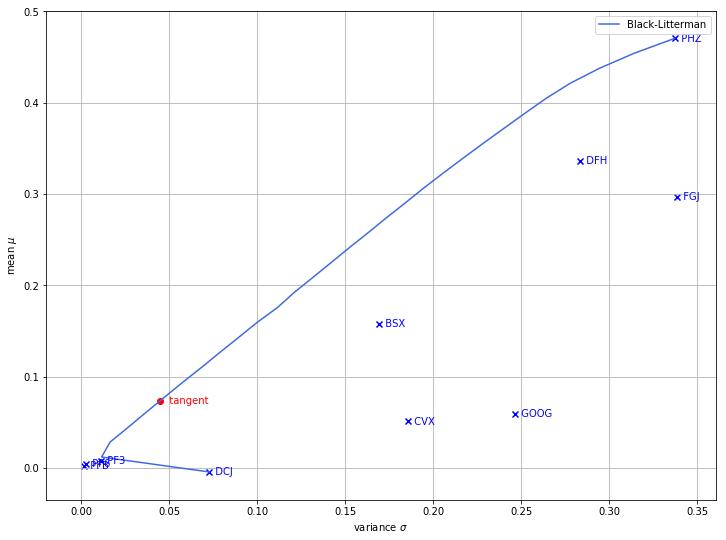

In [13]:
plt.figure(12,figsize=(12,9))
def display_assets(names, R, C, color='black'):
    scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color), grid(True)  # 画资产
    for i in range(n):
        text(C[i, i] ** .5, R[i], '  %s' % names[i], verticalalignment='center', color=color)  # 画标签

def display_frontier(result, label=None, color='black'):
    plt.text(result.tan_var ** .5, result.tan_mean, '   tangent', verticalalignment='center', color='red')
    plt.scatter(result.tan_var ** .5, result.tan_mean, marker='o', color='red'), grid(True)
    plt.plot(np.power(result.front_var, 0.5), result.front_mean, label=label, color=color), grid(True)  # 画有效边界
display_assets(names, Pi_adj + rf, C, color='blue')
display_frontier(res, label='Black-Litterman', color='royalblue')
xlabel('variance $\sigma$'), ylabel('mean $\mu$'), legend()
plt.show()

### 画出资产配置权重饼图

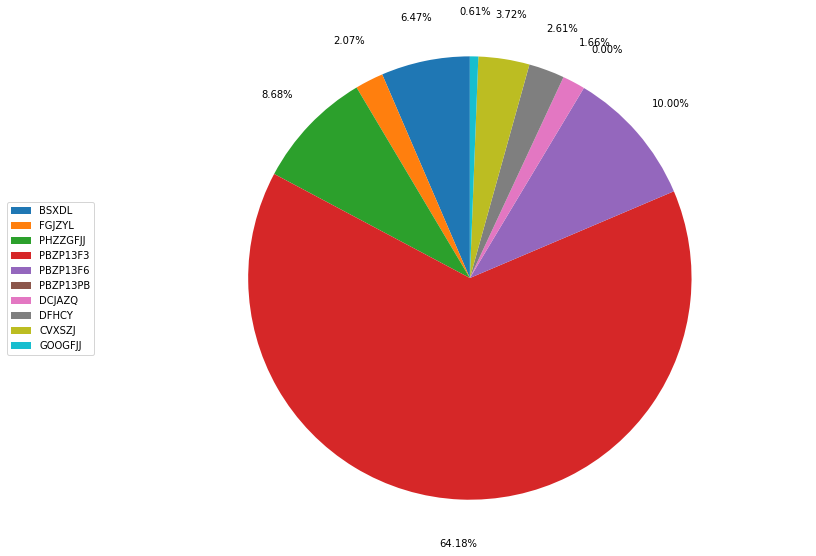

In [14]:
plt.figure(12,figsize=(12,9))
labels = [
          'BSXDL',
          'FGJZYL',
          'PHZZGFJJ',
          'PBZP13F3',
          'PBZP13F6',
          'PBZP13PB',
          'DCJAZQ',
          'DFHCY',
          # 'AAPL',
          'CVXSZJ',
          'GOOGFJJ',
          # 'MSFT'
]
plt.pie(res.W,startangle = 90,shadow=False,autopct='%2.2f%%',pctdistance = 1.2)
plt.axis('equal')
plt.legend(loc='center left',bbox_to_anchor=(-0.2, 0.5),labels=labels)
plt.show()

## 计算所得权重在过去的实际收益曲线

In [15]:
def solve_demo(returns,weight):
    rows, cols = returns.shape

    net = empty([rows, cols])
    ret = zeros(cols)
    for i in range(rows):
        net[i, 0] =  weight[i]
    for r in range(rows):
        for c in range(1,cols):
            returns[r, c] += 1
            net[r, c] = returns[r, c] * net[r, c-1]
    for c in range(cols):
        for r in range(rows):
            ret[c] += net[r, c]
    # print(ret[0])

    t = np.arange(1,240,1)
    xnew = np.linspace(t.min(), t.max(), 1000)  # 300 represents number of points to make between T.min and T.max
    power_smooth = spline(t, ret, xnew)
    plt.plot(xnew, power_smooth)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


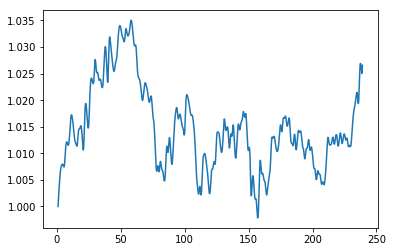

In [16]:
solve_demo(ret,res.W)